In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import joblib

In [16]:
import os

for root, dirs, files in os.walk("models"):
    for f in files:
        if "rf_dose_features" in f:
            print(os.path.join(root, f))
        

models/rf_dose_features.json
models/rf_dose_features_prod.json


In [12]:
# Paths

TRAIN_CSV = "data/training/train.csv"
MODEL_PATH = "models/rf_dose_regressor_prod.joblib"
FEATURES_JSON = "models/rf_dose_features_prod.json"

In [13]:
# Load training data
df = pd.read_csv(TRAIN_CSV)

In [14]:
# Load feature contract
with open(FEATURES_JSON, 'r') as f:
    obj = json.load(f)
features = obj['features'] if isinstance(obj, dict) else obj

In [17]:
# X / y 
X = df[features].copy()
y = df["irrigation_seconds"].astype(float).copy()

In [19]:
# Load base model parameters from saved artefact
base_model = joblib.load(MODEL_PATH)

In [22]:
#LOOCV retraining
from numpy import mean


loo = LeaveOneOut()
y_true, y_pred = [], []

for train_idx, test_idx in loo.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    model = RandomForestRegressor(**base_model.get_params())
    model.fit(X_train, y_train)
    
    pred = float(model.predict(X_test)[0])
    y_true.append(float(y_test.values[0]))
    y_pred.append(pred)

mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred) ** 0.5


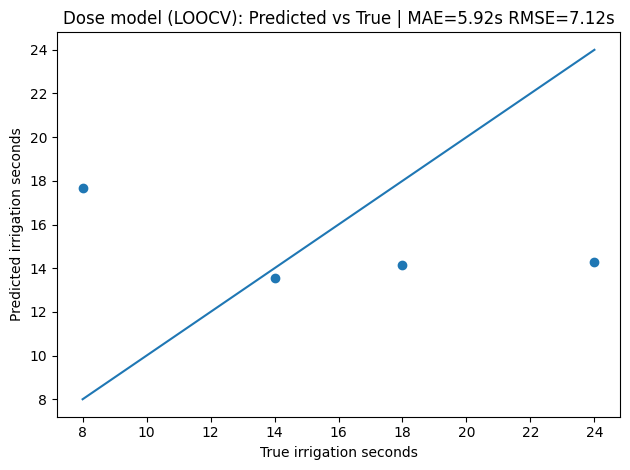

In [23]:
# Plot
plt.figure()
plt.scatter(y_true, y_pred)
minv, maxv = min(y_true + y_pred), max(y_true + y_pred)
plt.plot([minv, maxv], [minv, maxv])
plt.xlabel("True irrigation seconds")
plt.ylabel("Predicted irrigation seconds")
plt.title(f"Dose model (LOOCV): Predicted vs True | MAE={mae:.2f}s RMSE={rmse:.2f}s")
plt.tight_layout()

In [24]:
# Save figure
plt.savefig("docs/figures/predicted_vs_true_dose_model_loocv.png")
plt.show()

<Figure size 640x480 with 0 Axes>